In [1]:
%matplotlib inline
# import standard python modules
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Python classes for doing deconvolution
from pax_deconvolve.deconvolution import deconvolvers    

# Python module for estimating when deconvolutions have converged to a sufficient degree
from pax_deconvolve.deconvolution import assess_convergence

# Python module for visualizing the results of the deconvolution
import pax_deconvolve.visualize as visualize

In [2]:
# set simulation parameters
LOG10_NUM_ELECTRONS = 5.0  # 10^7 detected electrons (over entire dateset)
NUM_SIMULATIONS = 100    # Number of PAX spectra to simulate
ENERGY_LOSS = np.arange(-8, 10, 0.01)  # energy loss values of RIXS to simulate over
REGULARIZATION_STRENGTHS = np.logspace(-3, -1, 10)  # Regularization strengths to try
ITERATIONS = 100    # Number of iterations to run simulations for
CV_FOLD = 3   # Number of folds to use for cross validation

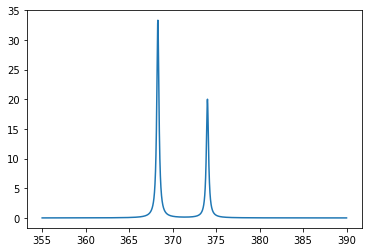

In [3]:
# Make up photoemission spectrum and corresponding impulse response function
b2 = 0.15    # Half of photoemission peak broadening
binding_energies = np.arange(355, 390, 0.01)
photoemission_spectrum = 5*(b2)/((binding_energies-368.3)**2+(b2)**2)+3*(b2)/((binding_energies-374.0)**2+(b2)**2)
norm_factor = np.sum(photoemission_spectrum)
impulse_response = {
    'x': -1*binding_energies,
    'y': np.flipud(photoemission_spectrum)/norm_factor
}
plt.figure()
plt.plot(binding_energies, photoemission_spectrum)

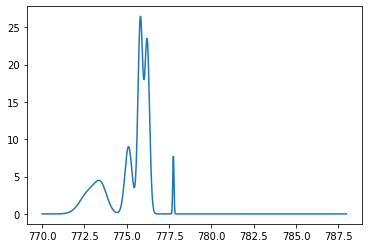

In [4]:
# Make up X-ray spectrum
photon_energies = np.arange(770, 788, 0.02)
p1 = 8*np.exp(-((photon_energies-777.75)/0.05)**2)
p2 = 23*np.exp(-((photon_energies-776.2)/0.2)**2)
p3 = 26*np.exp(-((photon_energies-775.8)/0.2)**2)
p4 = 9*np.exp(-((photon_energies-775.1)/0.3)**2)
p5 = 3*np.exp(-((photon_energies-773.5)/0.5)**2)
p6 = 3*np.exp(-((photon_energies-772.8)/0.75)**2)
xray_spectrum = p1+p2+p3+p4+p5+p6
plt.figure()
plt.plot(photon_energies, xray_spectrum)

In [5]:
# Calculate PAX spectra
"""
noiseless_pax_spectrum = convolve(
    xray_spectrum,
    impulse_response['y'],
    mode='valid'
)
num_pax_spectra = 5
counts = 10.0**LOG10_NUM_ELECTRONS 
single_photon = num_pax_spectra*np.sum(noiseless_pax_spectrum)/counts
pax_spectra = []
for i in range(num_pax_spectra):
    pax_spectrum = np.random.poisson(noiseless_pax_spectrum/single_photon)*single_photon
    pax_spectra.append(pax_spectrum)

# plot an example pax spectrum
plt.figure()
plt.plot(pax_spectra[0])
"""

"\nnoiseless_pax_spectrum = convolve(\n    xray_spectrum,\n    impulse_response['y'],\n    mode='valid'\n)\nnum_pax_spectra = 5\ncounts = 10.0**LOG10_NUM_ELECTRONS \nsingle_photon = num_pax_spectra*np.sum(noiseless_pax_spectrum)/counts\npax_spectra = []\nfor i in range(num_pax_spectra):\n    pax_spectrum = np.random.poisson(noiseless_pax_spectrum/single_photon)*single_photon\n    pax_spectra.append(pax_spectrum)\n\n# plot an example pax spectrum\nplt.figure()\nplt.plot(pax_spectra[0])\n"

In [6]:
binding_energies

array([355.  , 355.01, 355.02, ..., 389.97, 389.98, 389.99])

In [7]:
# Caclulate PAX spectra
from pax_deconvolve.pax_simulations import simulate_pax
impulse_response = simulate_pax.calculate_pax_impulse_response(binding_energies, photoemission_spectrum)
pax_x = simulate_pax._calculate_pax_kinetic_energy(photon_energies, binding_energies)
pax_y = simulate_pax.simulate(xray_spectrum,
                                                      impulse_response['y'],
                                                     10.0**LOG10_NUM_ELECTRONS,
                                                     500)

In [17]:
pax_x

array([415.  , 415.02, 415.04, ..., 466.96, 466.98, 467.  ])

In [9]:
# Perform deconvolution
deconvolver = deconvolvers.LRFisterGrid(
    impulse_response['x'],
    impulse_response['y'],
    pax_x,
    REGULARIZATION_STRENGTHS,
    ITERATIONS,
    xray_spectrum,
    CV_FOLD
)
# the ground truth X-ray spectrum is not known for real experiments and thus is an optional input argument to the deconvolver
_ = deconvolver.fit(pax_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.5s finished
/Users/dhigley/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


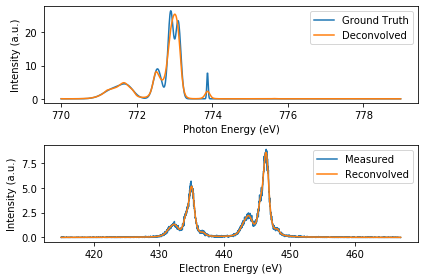

In [10]:
# Show result
visualize.plot_result(deconvolver)

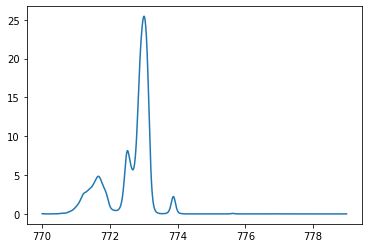

In [11]:
# plot result manually
plt.figure()
plt.plot(deconvolver.deconvolved_x, deconvolver.deconvolved_y_)

In [12]:
# save result
np.savetxt('test.csv', deconvolver.deconvolved_y_)